## **Load Data**

In [1]:
pip install bpemb

In [2]:
from bs4 import BeautifulSoup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import prune
import math
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
from torch.utils.data import Dataset
from collections import Counter
from typing import List
from transformers import AutoTokenizer
import pandas as pd
import re
from bpemb import BPEmb

In [3]:
# Load data from CSV, ignoring malformed lines
df = pd.read_csv("/content/lyrics.csv", on_bad_lines='skip')

# Remove the 'link' column as it's not needed
df = df.drop(columns=['link'])

# Calculate number of words in 'lyrics' assuming space as delimiter
df['token_count'] = df['lyrics'].apply(lambda x: len(x.split()))
print("Total number of tokens:", df['token_count'].sum())

# Clean the lyrics text using a predefined function
df['artist'] = df['artist'].str.replace(' Lyrics', '')
df['formatted'] = df.apply(lambda row: row['artist'] + (" " + row['lyrics'] if row['lyrics'] else ""), axis=1)
df['formatted_token_count'] = df['formatted'].apply(lambda x: len(x.split()))
max_formatted_tokens = df['formatted_token_count'].max()
print("Maximum number of tokens in 'formatted':", max_formatted_tokens)

# Determine and print the number of unique artists
unique_artists = df['artist'].nunique()
print("Number of unique artists:", unique_artists)

# Convert the 'formatted' column to lowercase
df['formatted'] = df['formatted'].str.lower()

# Remove unneeded columns to tidy up the DataFrame
df = df.drop(columns=['artist', 'token_count', 'lyrics', 'song_name', 'Unnamed: 0'])

Total number of tokens: 7619966
Maximum number of tokens in 'formatted': 3708
Number of unique artists: 542


In [4]:
class BPETokenizer:
    """
    Tokenizer based on Byte-Pair Encoding (BPE) to manage vocabulary and encoding/decoding of text.
    """
    def __init__(self, lang="en", vs=20000):
        """
        Initialize the BPE tokenizer with specified language and vocabulary size, adding special tokens.
        """
        self.bpemb = BPEmb(lang=lang, vs=vs)
        self.vocab_size = self.bpemb.vocab_size + 2  # Account for PAD and UNK tokens

        # Mapping from words to indices, offset by 2 to accommodate special tokens
        self.word_index = {word: idx + 2 for idx, word in enumerate(self.bpemb.words)}
        self.word_index["<PAD>"] = 0
        self.word_index["<UNK>"] = 1

        # Reverse mapping from indices to words
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def encode(self, text):
        """
        Convert text to a list of indices. Unknown words are mapped to <UNK>.
        """
        return [self.word_index.get(word, 1) for word in self.bpemb.encode(text)]

    def decode(self, indices):
        """
        Convert a list of indices back to text, skipping special tokens.
        """
        return ''.join(self.index_word.get(idx, "<UNK>") for idx in indices if idx > 1)

    def get_vocab_size(self):
        """
        Return the total vocabulary size, including special tokens.
        """
        return self.vocab_size


class TransformersTextDataset(Dataset):
    """
    Dataset class for text data prepared for training transformer models, handling tokenization and segmentation.
    """
    def __init__(self, texts, seq_length, lang="en", vs=20000):
        """
        Initialize dataset with texts, sequence length, and tokenizer parameters.
        """
        self.tokenizer = BPETokenizer(lang=lang, vs=vs)
        self.seq_length = seq_length
        self.tokenized_segments = self.tokenize_and_segment_texts(texts)

    def tokenize_and_segment_texts(self, texts):
        """
        Tokenize input texts and split into fixed-size segments, padding as needed.
        """
        tokenized_segments = []
        pad_id = self.tokenizer.word_index["<PAD>"]
        for text in texts:
            encoded = self.tokenizer.encode(text)
            padded_length = (len(encoded) + self.seq_length - 1) // self.seq_length * self.seq_length
            encoded.extend([pad_id] * (padded_length - len(encoded)))

            chunks = [encoded[i:i + self.seq_length] for i in range(0, len(encoded), self.seq_length)]
            tokenized_segments.extend(chunks)
        return tokenized_segments

    def unique_words(self):
        """
        Calculate the number of unique words in the tokenized segments, excluding special tokens.
        """
        return len(set(word for segment in self.tokenized_segments for word in segment if word > 1))

    def __len__(self):
        """
        Return the number of segments in the dataset.
        """
        return len(self.tokenized_segments)

    def __getitem__(self, idx):
        """
        Retrieve a pair of input-target sequences from the dataset by index.
        """
        segment = self.tokenized_segments[idx]
        return torch.tensor(segment[:-1], dtype=torch.long), torch.tensor(segment[1:], dtype=torch.long)

In [5]:
# Assume 'df' is your DataFrame and 'formatted' is the column with text data
texts = df['formatted'].tolist()

# Initialize dataset with first 1000 formatted texts, a sequence length of 64, and a vocab size of 5000
dataset = TransformersTextDataset(texts[:7500], seq_length=256, vs=5000)
print(f'Number of unique words in dataset: {dataset.unique_words()}')
print(f'Vocabulary size of tokenizer: {dataset.tokenizer.get_vocab_size()}')

# Calculate train/test split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split dataset into training and testing parts
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Output sizes of the splits
print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Create DataLoaders for batch processing of training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs5000.model


100%|██████████| 315918/315918 [00:00<00:00, 11831703.43B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs5000.d100.w2v.bin.tar.gz


100%|██████████| 1888515/1888515 [00:00<00:00, 36177402.13B/s]


Number of unique words in dataset: 4677
Vocabulary size of tokenizer: 5002
Training dataset size: 14178
Test dataset size: 3545


In [6]:
# Use GPU if available (I used L4 from Google Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Agree to Disagree**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as LA
import torch.optim as optim
import numpy as np

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embed size needs to be divisible by heads"

        self.values = nn.Linear(embed_size, heads * self.head_dim, bias=False)
        self.keys = nn.Linear(embed_size, heads * self.head_dim, bias=False)
        self.queries = nn.Linear(embed_size, heads * self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Transform and then split into [N, heads, seq_len, head_dim]
        values = self.values(values).view(N, value_len, self.heads, self.head_dim)
        keys = self.keys(keys).view(N, key_len, self.heads, self.head_dim)
        queries = self.queries(query).view(N, query_len, self.heads, self.head_dim)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=-1)
        attention = self.dropout(attention)

        # Combine attention and values
        out = torch.einsum("nhql,nlhd->nqhd", attention, values).contiguous()
        out = out.view(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)

        # Metrics computation for each head combination
        ortho_reg = torch.zeros((self.heads, self.heads)).to(query.device)
        intra_head_non_ortho = torch.zeros((self.heads, self.heads)).to(query.device)
        head_output_disagreement = torch.zeros((self.heads, self.heads)).to(query.device)
        attended_pos_disagreement = torch.zeros(self.heads).to(query.device)

        for i in range(self.heads):
            for j in range(self.heads):
                if i != j:
                    # Calculate cosine similarity for disagreement between heads
                    head_output_disagreement[i, j] = -1 * F.cosine_similarity(
                        out[:, :, self.head_dim * i:self.head_dim * (i + 1)],
                        out[:, :, self.head_dim * j:self.head_dim * (j + 1)],
                        dim=-1
                    ).mean()

                    # Orthogonality and intra-head non-orthogonality
                    qi = queries[:, :, i, :].contiguous().view(N * query_len, self.head_dim)
                    qj = queries[:, :, j, :].contiguous().view(N * query_len, self.head_dim)
                    ortho_reg[i, j] = (torch.mm(qi.t(), qj)).abs().sum()

                    # Intra-head non-orthogonality using context vectors
                    ci = (attention[:, i, :, :] @ values[:, :, i, :]).view(N * query_len, self.head_dim)
                    cj = (attention[:, j, :, :] @ values[:, :, j, :]).view(N * query_len, self.head_dim)
                    intra_head_non_ortho[i, j] = (torch.mm(ci.t(), cj)).norm()

            # Attended position disagreement within each head
            attended_pos_disagreement[i] = torch.var(attention[:, i, :, :], dim=1).mean()

        metrics = {
            'ortho_reg': ortho_reg,
            'intra_head_non_ortho': intra_head_non_ortho,
            'head_output_disagreement': head_output_disagreement,
            'attended_pos_disagreement': attended_pos_disagreement
        }

        return out, metrics

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000, device='cpu'):
        super(PositionalEncoding, self).__init__()
        self.device = device
        self.encoding = torch.zeros(max_len, embed_size, device=device)
        position = torch.arange(0, max_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_size, 2, device=device).float() * -(math.log(10000.0) / embed_size))

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].detach()

class DecoderLayer(nn.Module):
    def __init__(self, embed_size, heads, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.multihead_attention = MultiHeadAttention(embed_size, heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, embed_size * 4),
            nn.ReLU(),
            nn.Linear(embed_size * 4, embed_size),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        attention_output, attn_metrics = self.multihead_attention(src, src, src, mask=src_mask)
        src = src + self.dropout(attention_output)
        src = self.norm1(src)

        ff_output = self.feed_forward(src)
        src = src + self.dropout(ff_output)
        src = self.norm2(src)

        return src, attn_metrics

class Decoder(nn.Module):
    def __init__(self, embed_size, heads, num_layers, max_len, vocab_size = 5000, dropout=0.1):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size, max_len, device=device)
        self.layers = nn.ModuleList([DecoderLayer(embed_size, heads, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(embed_size, vocab_size)
        self.embed_size = embed_size

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src, src_mask=None):
        src = self.embed(src) * math.sqrt(self.embed_size)
        src = self.pos_encoder(src)
        src = self.dropout(src)

        if src_mask is None:
            src_mask = self.generate_square_subsequent_mask(src.size(1)).to(src.device)

        metrics = []
        for layer in self.layers:
            src, layer_metrics = layer(src, src_mask)
            metrics.append(layer_metrics)

        output = self.out_proj(src)  # Projecting to vocabulary space
        return output, metrics

In [10]:
# Parameters
embed_size = 128
num_heads = 8
num_layers = 6
max_len = 256
dropout_rate = 0.1
vocab_size = 5002

# Instantiate the model
model = Decoder(embed_size=embed_size, heads=num_heads, num_layers=num_layers, max_len=max_len, vocab_size = vocab_size, dropout=dropout_rate)

In [11]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Loss function
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [12]:
model.to(device)

metrics_list = []
batch_losses = []

# Number of epochs to train the model
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        output, metrics = model(data)

        # Convert metrics from Tensors to numpy arrays or Python scalars
        converted_metrics_epoch = []
        for metric_dict in metrics:
            converted_dict = {}
            for key, metric in metric_dict.items():
                if metric.numel() == 1:
                    converted_dict[key] = metric.item()  # Convert scalar tensor to a Python number
                else:
                    converted_dict[key] = metric.detach().cpu().numpy()
            converted_metrics_epoch.append(converted_dict)

        metrics_list.append(converted_metrics_epoch)

        # Reshape output and targets for the loss calculation
        output = output.view(-1, vocab_size)
        targets = targets.view(-1)

        # Compute loss
        loss = criterion(output, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        batch_losses.append(loss.item())

    print(f'Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader)}')

Epoch 1, Average Loss: 5.366656554711832


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"The model has {num_params:,} trainable parameters.")

The model has 2,472,842 trainable parameters.


In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
num_epochs = len(metrics_list)
num_layers = len(metrics_list[0]) if num_epochs > 0 else 0

# Initialize metric arrays
ortho_reg = np.zeros((num_layers, num_epochs))
intra_head_non_ortho = np.zeros((num_layers, num_epochs))
attended_pos_disagreement = np.zeros((num_layers, num_epochs))
head_output_disagreement = np.zeros((num_layers, num_epochs))

# Fill metric arrays
for epoch_idx, epoch in enumerate(metrics_list):
    for layer_idx, layer_metrics in enumerate(epoch):
        # Calculate the mean of each metric array and store it
        ortho_reg[layer_idx, epoch_idx] = np.mean(layer_metrics['ortho_reg'])
        intra_head_non_ortho[layer_idx, epoch_idx] = np.mean(layer_metrics['intra_head_non_ortho'])
        attended_pos_disagreement[layer_idx, epoch_idx] = np.mean(layer_metrics['attended_pos_disagreement'])
        head_output_disagreement[layer_idx, epoch_idx] = np.mean(layer_metrics['head_output_disagreement'])

In [16]:
print(ortho_reg.shape)
print(intra_head_non_ortho.shape)
print(attended_pos_disagreement.shape)
print(head_output_disagreement.shape)

(6, 222)
(6, 222)
(6, 222)
(6, 222)


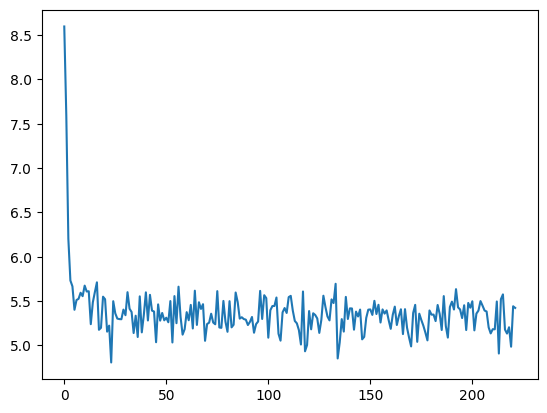

In [17]:
bacthes = [i for i in range(len(batch_losses))]

plt.plot(bacthes, batch_losses)
plt.show()

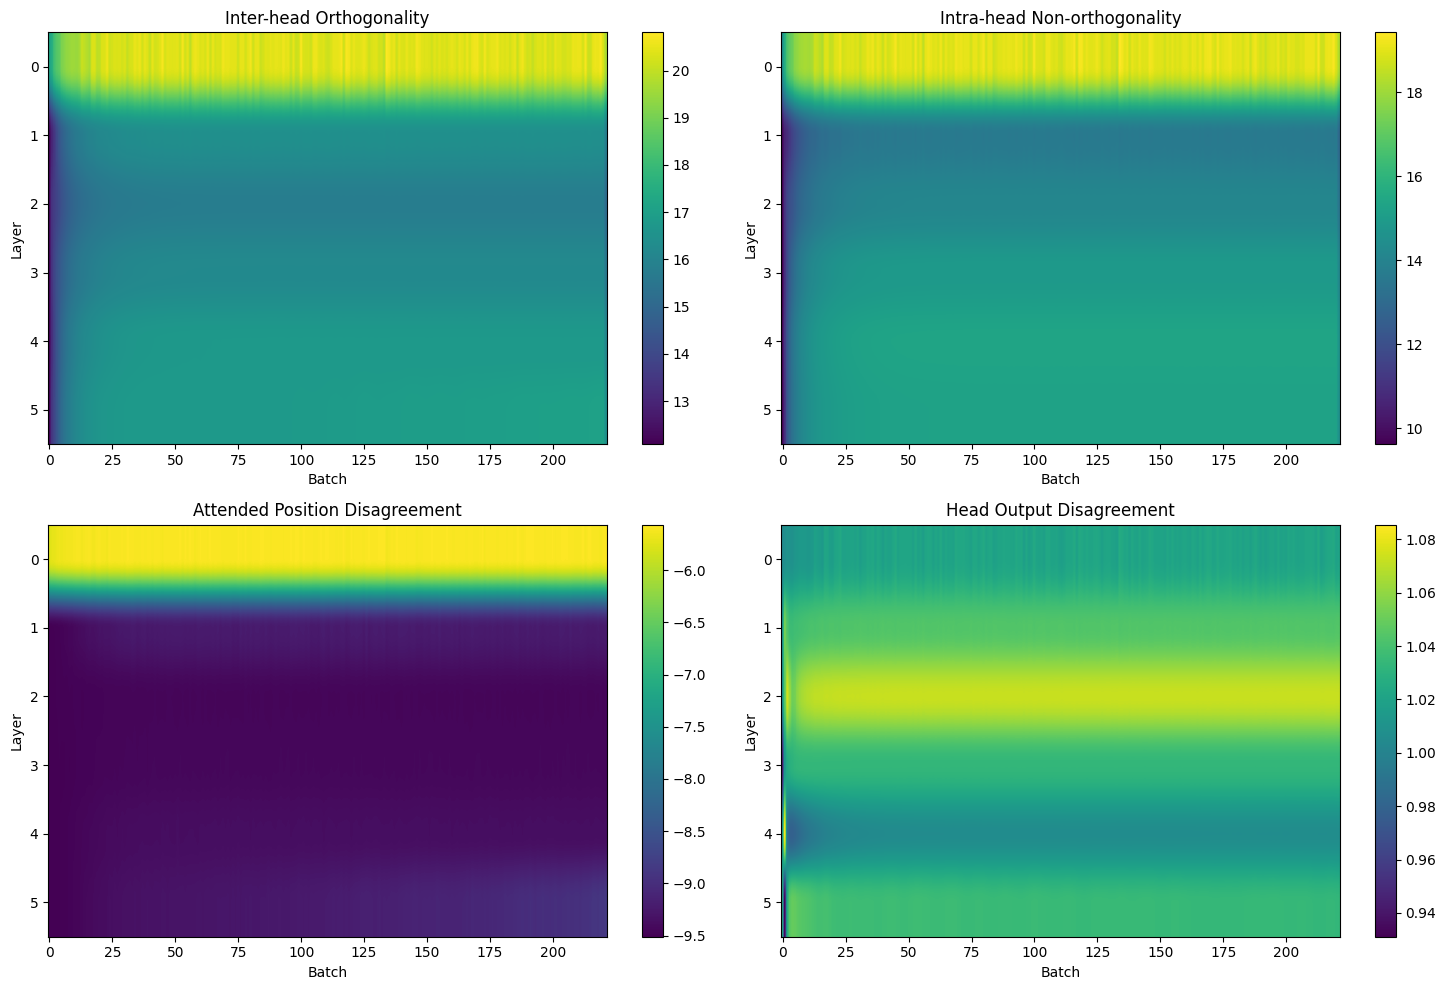

In [18]:
# Plotting with colorbar legend for magnitude
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
cmap = 'viridis'  # Color map for grid plots

# Orthogonal Regularization
ortho_img = axs[0, 0].imshow(np.log(ortho_reg), cmap=cmap, aspect='auto')
axs[0, 0].set_title('Inter-head Orthogonality')
axs[0, 0].set_xlabel('Batch')
axs[0, 0].set_ylabel('Layer')
fig.colorbar(ortho_img, ax=axs[0, 0], orientation='vertical')

# Intra-head Non-orthogonality
intra_img = axs[0, 1].imshow(np.log(intra_head_non_ortho), cmap=cmap, aspect='auto')
axs[0, 1].set_title('Intra-head Non-orthogonality')
axs[0, 1].set_xlabel('Batch')
axs[0, 1].set_ylabel('Layer')
fig.colorbar(intra_img, ax=axs[0, 1], orientation='vertical')

# Attended Position Disagreement
attended_img = axs[1, 0].imshow(np.log(attended_pos_disagreement), cmap=cmap, aspect='auto')
axs[1, 0].set_title('Attended Position Disagreement')
axs[1, 0].set_xlabel('Batch')
axs[1, 0].set_ylabel('Layer')
fig.colorbar(attended_img, ax=axs[1, 0], orientation='vertical')

# Head Output Disagreement
head_img = axs[1, 1].imshow(np.exp(head_output_disagreement), cmap=cmap, aspect='auto')
axs[1, 1].set_title('Head Output Disagreement')
axs[1, 1].set_xlabel('Batch')
axs[1, 1].set_ylabel('Layer')
fig.colorbar(head_img, ax=axs[1, 1], orientation='vertical')

plt.tight_layout()
plt.show()

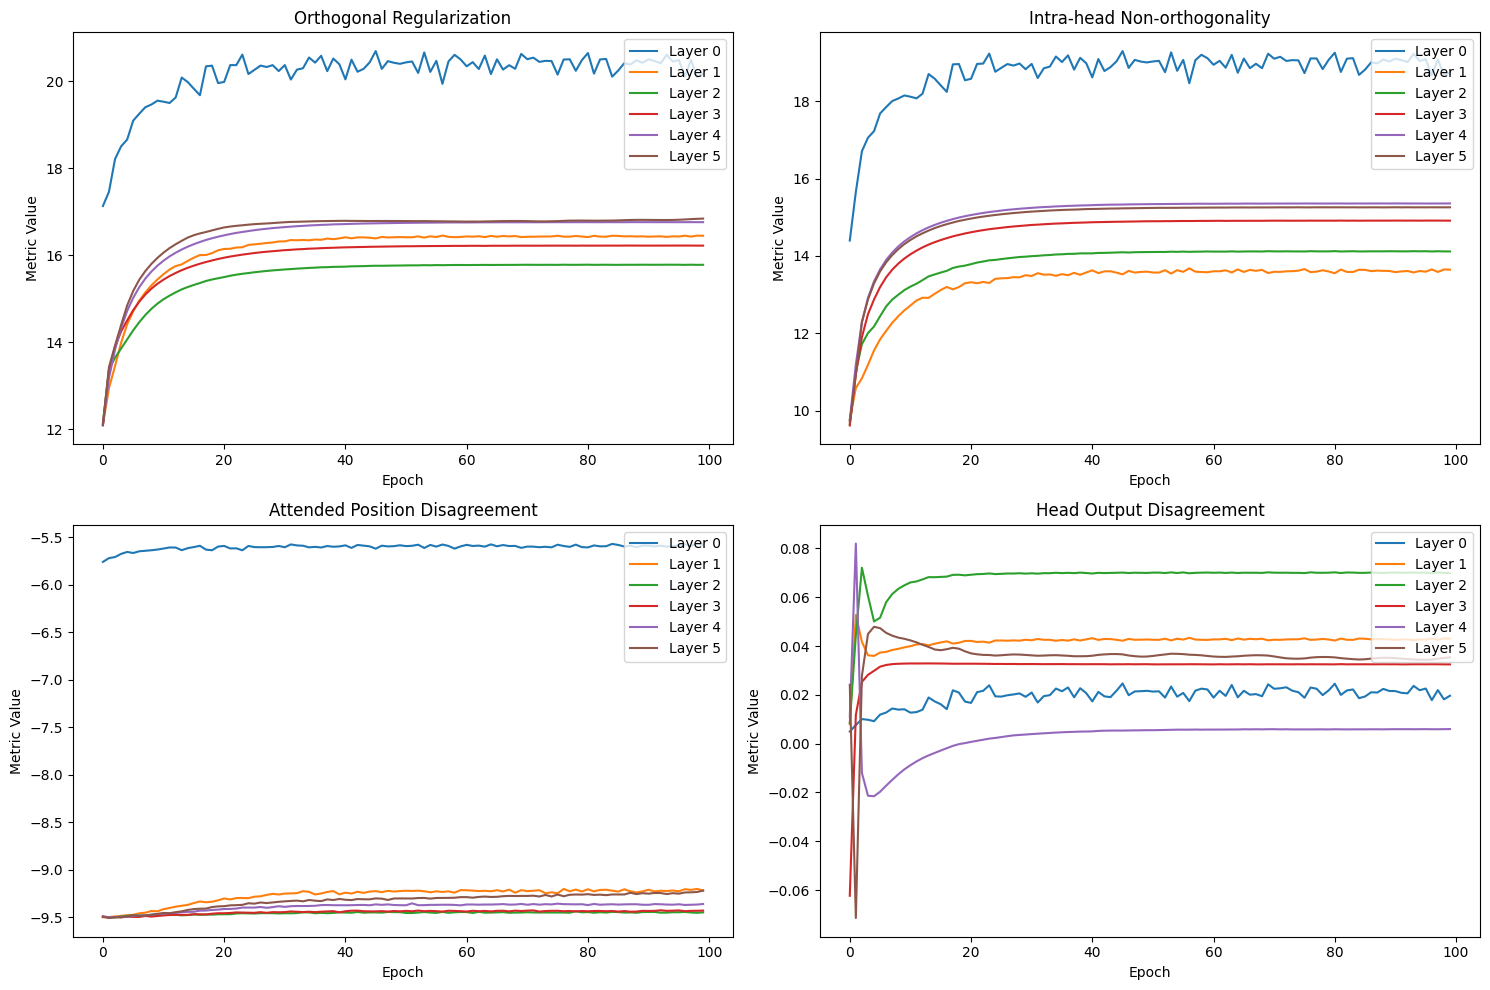

In [19]:
num_display_epochs = 100  # Change this value to display more or fewer epochs

# Create subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

metrics_titles = ['Orthogonal Regularization', 'Intra-head Non-orthogonality',
                  'Attended Position Disagreement', 'Head Output Disagreement']
data = [np.log(ortho_reg), np.log(intra_head_non_ortho), np.log(attended_pos_disagreement), head_output_disagreement]

# Plotting each metric in a subplot
for idx, ax in enumerate(axs.flat):
    # Plot each layer's data as a separate line
    for layer_idx in range(num_layers):
        ax.plot(data[idx][layer_idx, :num_display_epochs], label=f'Layer {layer_idx}')

    ax.set_title(metrics_titles[idx])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.legend(loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import json
import numpy as np

# Apply batch losses to each layer's metrics
for batch_index, batch in enumerate(metrics_list):
    for layer in batch:
        layer['batch_loss'] = batch_losses[batch_index]

# Flatten the list of lists of dictionaries and add epoch and layer information
flat_metrics = []
for epoch_index, epoch in enumerate(metrics_list):
    for layer_index, layer_metrics in enumerate(epoch):
        for key, value in layer_metrics.items():
            if isinstance(value, np.ndarray):
                layer_metrics[key] = value.tolist()
        layer_metrics['epoch'] = epoch_index
        layer_metrics['layer'] = layer_index
        flat_metrics.append(layer_metrics)

# Save to JSON
json_file = 'metrics_list_0_8_0.01.json'
with open(json_file, 'w') as file:
    json.dump(flat_metrics, file, indent=4)

# If you need to output the path or any message
print(f"JSON file saved as {json_file}")

JSON file saved as metrics_list_0_8_0.01.json


In [ ]:
# Load the JSON data
with open('/content/metrics_list_0_8_0.01.json', 'r') as file:
    data = json.load(file)

# Prepare data for DataFrame
processed_data = []
for entry in data:
    layer_data = {
        'epoch': entry['epoch'],
        'layer': entry['layer'],
        'batch_loss': entry['batch_loss']
    }

    # Process metrics that are nested lists
    for key, value in entry.items():
        if isinstance(value, list) and all(isinstance(i, list) for i in value):
            # Flatten the list and calculate the average and variance, ignoring zeros
            flat_list = [item for sublist in value for item in sublist if item != 0]
            if flat_list:
                average = np.mean(flat_list)
                variance = np.var(flat_list)
                layer_data[f'{key}_mean'] = average
                layer_data[f'{key}_var'] = variance
        elif isinstance(value, list) and not any(isinstance(i, list) for i in value):
            if value:
                average = np.mean(value)
                variance = np.var(value)
                layer_data[f'{key}_mean'] = average
                layer_data[f'{key}_var'] = variance

    processed_data.append(layer_data)

# Create a DataFrame and save to CSV
df = pd.DataFrame(processed_data)
csv_file_path = '0_8_0.01.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data has been processed and saved to {csv_file_path}")

Data has been processed and saved to 0_8_0.01.csv


## **Analysis**

In [ ]:
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

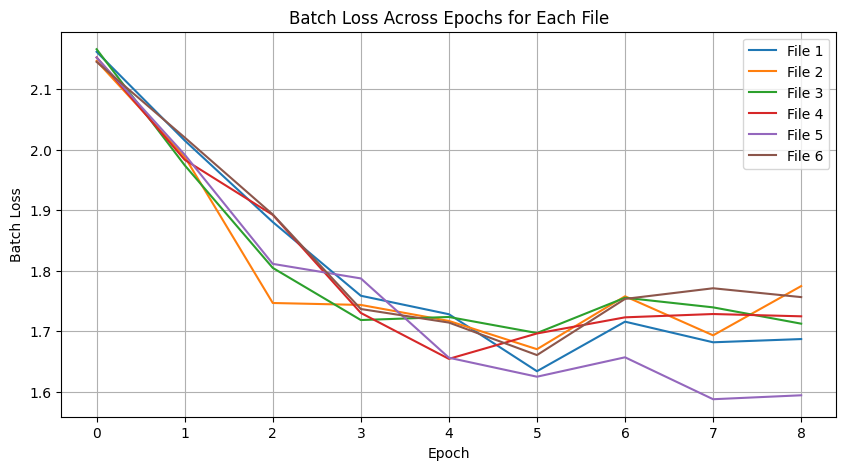

In [ ]:
# Raw GitHub URLs to the JSON files
file_urls = [
    'https://raw.githubusercontent.com/MSaadAsad/transformers/main/Metrics%20Data/metrics_list_0.1_2_0.01.json',
    'https://raw.githubusercontent.com/MSaadAsad/transformers/main/Metrics%20Data/metrics_list_0.1_4_0.01.json',
    'https://raw.githubusercontent.com/MSaadAsad/transformers/main/Metrics%20Data/metrics_list_0.1_8_0.01.json',
    'https://raw.githubusercontent.com/MSaadAsad/transformers/main/Metrics%20Data/metrics_list_0_2_0.01.json',
    'https://raw.githubusercontent.com/MSaadAsad/transformers/main/Metrics%20Data/metrics_list_0_4_0.01.json',
    'https://raw.githubusercontent.com/MSaadAsad/transformers/main/Metrics%20Data/metrics_list_0_8_0.01.json'
]

# Setting up the plot
plt.figure(figsize=(10, 5))

for file_index, url in enumerate(file_urls):
    response = requests.get(url)
    data = response.json()

    # Extracting batch_loss for each epoch in this file
    epoch_losses = [record['batch_loss'] for record in data]
    epochs = [record['epoch'] for record in data]

    # Plot each file's data as a separate line
    plt.plot(epochs[:50], np.log(epoch_losses[:50]), label=f'File {file_index + 1}')

# Adding labels and title
plt.title('Batch Loss Across Epochs for Each File')
plt.xlabel('Epoch')
plt.ylabel('Batch Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import requests

In [ ]:
def plot_metrics(size, dropout, metric):
    base_url = 'https://raw.githubusercontent.com/MSaadAsad/transformers/main/Metrics%20Data/'
    file_name = f'metrics_list_{dropout}_{size}_0.01.json'
    response = requests.get(base_url + file_name)
    data = response.json()

    num_epochs = 30
    num_layers = 6

    # Determine folder path for saving images
    folder_name = f'output_size_{size}_dropout_{dropout}'
    save_dir = os.path.join('/content', folder_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Record the initial batch loss for comparison
    initial_batch_loss = data[0]["batch_loss"]

    for frame in range(num_epochs):
        plt.figure(figsize=(10, 8))
        layer_data = [entry for entry in data if entry['epoch'] == frame]
        for i in range(num_layers):
            ax = plt.subplot(2, 3, i + 1)
            layer_specific_data = [entry for entry in layer_data if entry['layer'] == i]
            if layer_specific_data:
                matrix = layer_specific_data[0][metric]
                if metric != 'head_output_disagreement' and np.min(matrix) > 0:
                    matrix = np.log(matrix)
                c = ax.imshow(matrix, cmap='RdYlGn', interpolation='nearest', vmin = -0.8, vmax = 0.8)
                ax.set_xticks(np.arange(len(matrix)))
                ax.set_yticks(np.arange(len(matrix)))
                colorbar = plt.colorbar(c, ax=ax)
                ax.set_title(f'Layer {i+1}')
                ax.set_yticks(np.arange(len(matrix)))
                ax.set_yticklabels(np.arange(len(matrix)))

        current_batch_loss = layer_data[0]["batch_loss"] if layer_data else initial_batch_loss
        loss_percentage = 100 * current_batch_loss / initial_batch_loss if initial_batch_loss else 0
        plt.suptitle(f'Epoch {frame} , Current Loss: {loss_percentage:.2f}% of Initial')
        plt.savefig(os.path.join(save_dir, f'{metric}_epoch_{frame}.png'))
        plt.close()

In [ ]:
sizes = [2, 4, 8]
dropouts = [0, 0.1]
metrics = ['head_output_disagreement']

for size in sizes:
    for dropout in dropouts:
        for metric in metrics:
            plot_metrics(size, dropout, metric)
            print(f"Images saved for size {size}, dropout {dropout}, metric {metric}")

Images saved for size 2, dropout 0, metric head_output_disagreement
Images saved for size 2, dropout 0.1, metric head_output_disagreement
Images saved for size 4, dropout 0, metric head_output_disagreement
Images saved for size 4, dropout 0.1, metric head_output_disagreement
Images saved for size 8, dropout 0, metric head_output_disagreement
Images saved for size 8, dropout 0.1, metric head_output_disagreement


In [ ]:
from google.colab import files
import shutil

# List of directory names to be zipped and downloaded
directory_names = [
    'output_size_2_dropout_0',
    'output_size_2_dropout_0.1',
    'output_size_4_dropout_0',
    'output_size_4_dropout_0.1',
    'output_size_8_dropout_0',
    'output_size_8_dropout_0.1',
]

# Iterate through each directory, zip it, and download the zip
for directory_name in directory_names:
    shutil.make_archive(directory_name, 'zip', directory_name)
    files.download(f"{directory_name}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Analytics**

In [ ]:
# Calculate the mean for each metric
averaged_data = []
for entry in data:
    processed_entry = {
        "epoch": entry["epoch"],
        "layer": entry["layer"],
        "batch_loss": entry["batch_loss"],
        "ortho_reg_mean": sum(sum(row) for row in entry["ortho_reg"]) / 4,
        "intra_head_non_ortho_mean": sum(sum(row) for row in entry["intra_head_non_ortho"]) / 4,
        "head_output_disagreement_mean": sum(sum(row) for row in entry["head_output_disagreement"]) / 4,
        "attended_pos_disagreement_mean": sum(entry["attended_pos_disagreement"]) / len(entry["attended_pos_disagreement"])
    }
    averaged_data.append(processed_entry)

df = pd.DataFrame(averaged_data)
csv_path = '/content/averaged_metrics.csv'
df.to_csv(csv_path, index=False)
csv_path

'/content/averaged_metrics.csv'

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler

# Applying log transformation to the specified columns (adding a small constant to avoid log(0))
df['ortho_reg_mean'] = np.log(df['ortho_reg_mean'] + 1)
df['intra_head_non_ortho_mean'] = np.log(df['intra_head_non_ortho_mean'] + 1)
df['attended_pos_disagreement_mean'] = np.log(df['attended_pos_disagreement_mean'] + 1)

# Create interaction terms between 'layer' and other metrics
df['layer_ortho_reg'] = df['layer'] * df['ortho_reg_mean']
df['layer_intra_head'] = df['layer'] * df['intra_head_non_ortho_mean']
df['layer_head_output'] = df['layer'] * df['head_output_disagreement_mean']
df['layer_attended_pos'] = df['layer'] * df['attended_pos_disagreement_mean']

# Select features to be normalized
features = ['ortho_reg_mean', 'intra_head_non_ortho_mean', 'head_output_disagreement_mean',
            'attended_pos_disagreement_mean', 'layer_ortho_reg', 'layer_intra_head',
            'layer_head_output', 'layer_attended_pos', 'layer', 'epoch']

# Normalize the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Define the independent variables and add a constant to the model (intercept)
X = df[features]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Define the dependent variable
y = df['batch_loss']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             batch_loss   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     66.02
Date:                Wed, 01 May 2024   Prob (F-statistic):          5.51e-109
Time:                        18:17:31   Log-Likelihood:                -176.11
No. Observations:                1332   AIC:                             374.2
Df Residuals:                    1321   BIC:                             431.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

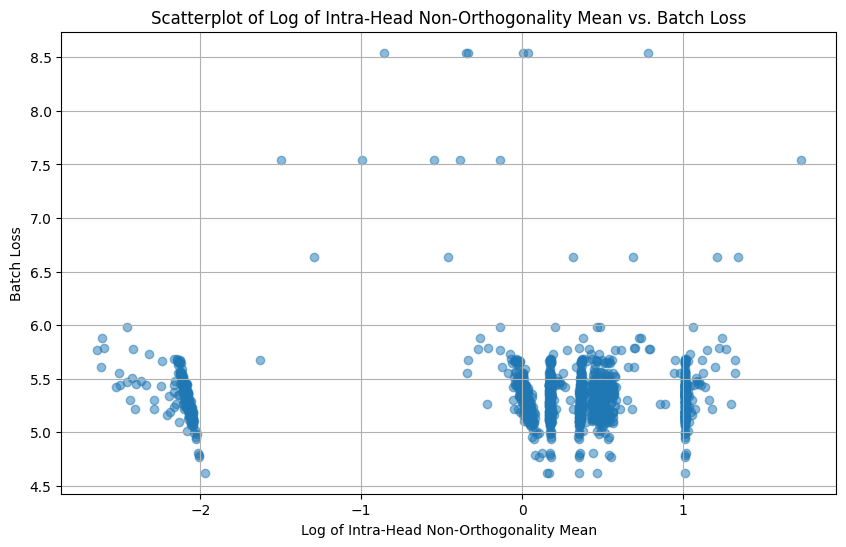

In [ ]:
df['log_intra_head_non_ortho_mean'] = np.log(df['intra_head_non_ortho_mean'] + 1)

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(df['head_output_disagreement_mean'], df['batch_loss'], alpha=0.5)
plt.title('Scatterplot of Log of Intra-Head Non-Orthogonality Mean vs. Batch Loss')
plt.xlabel('Log of Intra-Head Non-Orthogonality Mean')
plt.ylabel('Batch Loss')
plt.grid(True)
plt.show()

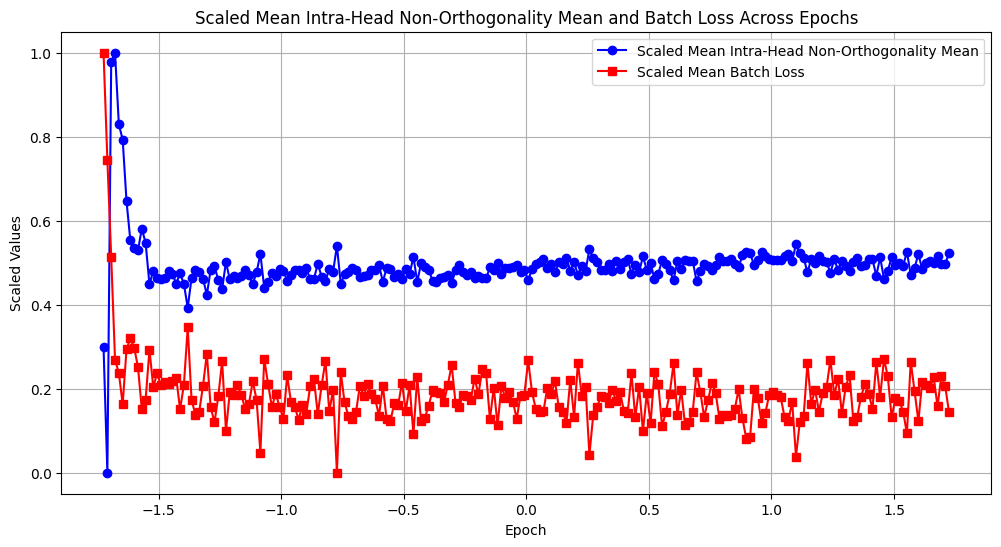

In [ ]:
# Grouping data by epoch and calculating the mean of non-orthogonality mean and batch_loss
epoch_means = df.groupby('epoch').agg({
    'head_output_disagreement_mean': 'mean',
    'batch_loss': 'mean'
}).reset_index()

# Normalize the values for plotting to compare trends on the same scale
from sklearn.preprocessing import MinMaxScaler

# Creating a scaler object
scaler = MinMaxScaler()

# Scaling the data
scaled_values = scaler.fit_transform(epoch_means[['head_output_disagreement_mean', 'batch_loss']])
epoch_means['scaled_head_output_disagreement_mean'] = scaled_values[:, 0]
epoch_means['scaled_batch_loss'] = scaled_values[:, 1]

# Plotting
plt.figure(figsize=(12, 6))

# Line plot for scaled intra_head_non_ortho_mean
plt.plot(epoch_means['epoch'], epoch_means['scaled_head_output_disagreement_mean'], marker='o', color='blue', label='Scaled Mean Intra-Head Non-Orthogonality Mean')

# Line plot for scaled batch_loss
plt.plot(epoch_means['epoch'], epoch_means['scaled_batch_loss'], marker='s', color='red', label='Scaled Mean Batch Loss')

plt.title('Scaled Mean Intra-Head Non-Orthogonality Mean and Batch Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()